# Remake q-zams M plot

16 Feb 2026

In [69]:
"""
# Plotting the stable BH mass distribution for several SFRD Z-distribution variations
"""
import matplotlib
from matplotlib import rc
import matplotlib.cm as cm
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import h5py as h5 
import os
import time
from astropy.table import Table
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import ListedColormap

from matplotlib.colors import LogNorm, LinearSegmentedColormap
from scipy.ndimage.filters import gaussian_filter
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FormatStrFormatter


import MinimumMassFunctions as mfunc
import importlib
importlib.reload(mfunc)


data_dir = '../data/'
simulation_data = '/mnt/home/lvanson/ceph/CompasOutput/v02.26.03/N1e7Grid_BBH_BHNS_optimized/'
sim_name = 'faccFIXEDbeta0.5zetaHG6.0RemMassFRYER2012SNDELAYED/'

######################################
## PLOT setttings
plt.rc('font', family='serif')
rc('text', usetex=False)
fsize, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 30, 18,20,30
for obj in ['axes','xtick','ytick']:
    plt.rc(obj, labelsize=MEDIUM_SIZE)          # controls default text sizes
for obj in ['figure','axes']:
    plt.rc(obj, titlesize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('legend', fontsize=SMALL_SIZE)     # legend fontsize



/var/folders/5d/vcxrsh5975l7d5n8t7vvc5pr0000gn/T/ipykernel_43376/2179758933.py:19: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter


In [8]:
sim_dir = data_dir + sim_name

rate_key = 'Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_zBinned'


with h5.File(sim_dir + '/COMPAS_Output_wWeights.h5','r') as File: #add output/ when on cluster
        redshifts                 = File[rate_key]['redshifts'][()]
        DCO_mask                  = File[rate_key]['DCOmask'][()] # Mask from DCO to merging systems  
        #(contains filter for RLOF>CE and optimistic CE)
        intrinsic_rate_density    = File[rate_key]['merger_rate'][()]
        
        print(File.keys())

<KeysViewHDF5 ['BSE_Double_Compact_Objects', 'BSE_RLOF', 'Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_zBinned']>


## Some helper functions

In [70]:
#########################################
# Read COMPAS DCO data
#########################################
def read_data(loc = '', verbose=False):
    """
        Read DCO, SYS and merger rate data, necesarry to make the plots in this 
        
        Args:
            loc                  --> [string] Location of data
            rate_key             --> [string] group key name of COMPAS HDF5 data that contains your merger rate
            read_SFRD            --> [bool] If you want to also read in sfr data
            verbose              --> [bool] If you want to print statements while reading in 

        Returns:
            DCO                        --> [astropy table] contains all your double compact object
            DCO_mask                   --> [array of bool] reduces your DCO table to your systems of interest (determined in CI)
            rate_mask                  --> [array of bool] reduces intrinsic_rate_density to systems (flavour) of interest
            redshifts                  --> [array of floats] list of redshifts where you calculated the merger rate
            Average_SF_mass_needed     --> [float]    Msun SF needed to produce the binaries in this simulation
            intrinsic_rate_density     --> [2D array] merger rate in N/Gpc^3/yr
            intrinsic_rate_density_z0  --> [2D array] merger rate in N/Gpc^3/yr at finest/lowest redshift bin calculated

    """
    print('Reading ',loc)
    ################################################
    ## Open hdf5 file
    File        = h5.File(loc ,'r')
    if verbose: print(File.keys(), File[rate_key].keys())
    
    # Older simulations use this naming
    dcokey,  syskey, CEcount, dcomask = 'DoubleCompactObjects', 'SystemParameters', 'CE_Event_Count', 'DCOmask' 
    if dcokey in File.keys():
        if verbose: print('using file with key', dcokey)
    # Newer simulations use this
    else:
        if verbose: print('using file with key', dcokey)
        dcokey,  syskey, CEcount, dcomask = 'BSE_Double_Compact_Objects', 'BSE_System_Parameters', 'CE_Event_Counter', 'DCOmask'
 
    print('using keys', File.keys(), File[dcokey].keys())
    
    DCO = Table()
    for dco_param in ['SEED', 'Mass(1)', 'Mass(2)', 'Stellar_Type(1)', 'Stellar_Type(2)','Metallicity@ZAMS(1)', 'Mass@ZAMS(1)', 'Mass@ZAMS(2)', CEcount]:
                    #   'MT_Donor_Hist(1)','MT_Donor_Hist(2)','dmMT(1)', 'dmMT(2)', 'dmWinds(1)', 'dmWinds(2)',
                    #    'SemiMajorAxis@DCO', 'Eccentricity@DCO', 'Optimistic_CE', 'Immediate_RLOF>CE', CEcount]:
                      
        DCO[dco_param] = File[dcokey][dco_param][()]
        
    DCO['M_moreMassive']         = np.maximum(File[dcokey]['Mass(1)'][()], File[dcokey]['Mass(2)'][()])
    DCO['M_lessMassive']         = np.minimum(File[dcokey]['Mass(1)'][()], File[dcokey]['Mass(2)'][()])
    DCO['Mchirp']                = np.divide(np.power(np.multiply(DCO['M_moreMassive'], DCO['M_lessMassive']), 3./5.), np.power(np.add(DCO['M_moreMassive'], DCO['M_lessMassive']), 1./5.))

    # SYS_DCO_seeds_bool           = np.isin(File[syskey]['SEED'][()], DCO['SEED']) #Bool to point SYS to DCO
    # # This needs to be done in two steps, otherwise the Snakemake workflow gets stuck for unknown reasons
    # for sys_param in ['Stellar_Type@ZAMS(1)', 'Stellar_Type@ZAMS(2)', 'Mass@ZAMS(1)', 'Mass@ZAMS(2)']:
    #     SYSvalues = File[syskey][sys_param][()]
    #     DCO[sys_param]  =  SYSvalues[SYS_DCO_seeds_bool] 

    File.close()
    
    print('Done with reading DCO data for this file :)')
    return DCO


#############################
def read_and_mask(sim_dir='', rate_key='Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_zBinned',
                  sim_name='', x_key='M_moreMassive', only_stable=True, only_CE=True):
    """
    This function reads and masks the data.
    """
    # Reading data ##
    DCO = read_data(loc = os.path.join(sim_dir, sim_name, 'COMPAS_Output_wWeights.h5')) # DCO data
    
    # Rate data
    with h5.File(os.path.join(sim_dir, sim_name,'COMPAS_Output_wWeights.h5'),'r') as File:
        if rate_key in File.keys():
            final_rate_key = rate_key
        else:
            final_rate_key = next((key for key in File.keys() if key.startswith('Rates_')), None)
        redshifts                 = File[final_rate_key]['redshifts'][()]
        DCO_mask                  = File[final_rate_key]['DCOmask'][()] # Mask from DCO to merging systems  
        intrinsic_rate_density    = File[final_rate_key]['merger_rate'][()]

    #############################
    # Masking data ##
    mask_start_t = time.time()
    CEcount = 'CE_Event_Count' if 'CE_Event_Count' in DCO.columns else 'CE_Event_Counter' # Old simulations use CE_Event_Count, newer ones CE_Event_Counter
    
    print('you are using ', CEcount, 'which should be in ', DCO.keys())

    #first bring it to the same shape as the rate table
    merging_BBH = DCO[DCO_mask]
    # Are you interested in only stable or only CE channels?
    if np.logical_and(only_stable, only_CE):
        channel_bool = np.full(len(merging_BBH), True)
        channel_string = 'All'
    elif only_stable:
        channel_bool = merging_BBH[CEcount] == 0
        channel_string = 'stable'
    elif only_CE:
        channel_bool = merging_BBH[CEcount] > 0
        channel_string = 'CE'
    else:
        raise ValueError(f"Both only_stable ={only_stable} and only_CE={only_CE}, set at least one to true")
                
    # we exclude CHE systems
    not_CHE  = np.full(len(merging_BBH), True) # Default to all systems being "not CHE" #merging_BBH['Stellar_Type@ZAMS(1)'] != 16 
    BBH_bool = np.logical_and(merging_BBH['Stellar_Type(1)'] == 14, merging_BBH['Stellar_Type(2)'] == 14)
    
    # Apply all masks
    merging_BBH         = merging_BBH[BBH_bool * not_CHE  * channel_bool]
    Red_intr_rate_dens  = intrinsic_rate_density[BBH_bool* not_CHE * channel_bool, :]
    
    mask_end_t = time.time()
    print('done masking data: ', mask_end_t - mask_start_t, 'seconds')
        
    return merging_BBH, Red_intr_rate_dens, channel_string, redshifts



In [71]:
#########################################
# Read LIgo data
#########################################
def read_ligo():
    color_plpeak = 'grey'
    ## grab Powerlaw + Peak data from O3
    mass_1 = np.linspace(2, 100, 1000)
    mass_ratio = np.linspace(0.1, 1, 500)
    with h5.File(data_dir+'o3only_mass_c_iid_mag_iid_tilt_powerlaw_redshift_mass_data.h5', "r") as f:
        mass_ppd = f["ppd"]
        mass_lines = f["lines"]
        mass_1_ppd = np.trapz(mass_ppd, mass_ratio, axis=0)
        mass_1_lower = np.percentile(mass_lines["mass_1"], 5, axis=0)
        mass_1_upper = np.percentile(mass_lines["mass_1"], 95, axis=0)
    ##############################
    return mass_1, mass_1_lower, mass_1_upper, mass_1_ppd


#########################################
def darken_color(hex_color, factor=0.7):
    """
    hex_color : str Hex color code (e.g., '#7CD0CE')
    factor : float Darkening factor between 0 (black) and 1 (original color).
        Default is 0.7
    Returns: str : Darkened hex color
    Example:
    --------
    >>> darken_color('#7CD0CE', 0.7)
    '#57918f'
    """
    # Remove '#' if present
    hex_color = hex_color.lstrip('#')
    
    # Convert hex to RGB
    r, g, b = int(hex_color[0:2], 16), int(hex_color[2:4], 16), int(hex_color[4:6], 16)
    
    # Darken by multiplying by factor
    r_dark = int(r * factor)
    g_dark = int(g * factor)
    b_dark = int(b * factor)
    
    # Ensure values are in valid range
    r_dark = max(0, min(255, r_dark))
    g_dark = max(0, min(255, g_dark))
    b_dark = max(0, min(255, b_dark))
    
    # Convert back to hex
    return f'#{r_dark:02x}{g_dark:02x}{b_dark:02x}'




# Let's go back to my analytical solutions for min MBH1, and MBH2

In [ ]:
#[3.5, 4.5, 5.5, 6.0, 6.5]
def get_table_and_min_MBH(beta = 0.5, zeta_list = [6.0], Fc1 = 0.34, sim_name = 'faccFIXEDbeta%szetaHG6.0RemMassFRYER2012SNDELAYED/'%(BETA) ):# 'THERMAL' #

     #'facc%szetaHG6.0RemMassFRYER2012SNDELAYED/'%(BETA)  #
     
     merging_BBH, Red_intr_rate_dens, channel_string, redshifts = read_and_mask(sim_name= sim_name,
                                             sim_dir=data_dir, 
                                             rate_key='Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_a0.02_b1.48_c4.45_d5.9_zBinned',
                                             only_stable=True, only_CE=False)

     merging_BBH.info()

     # print(np.unique(merging_BBH['MT_Donor_Hist(1)'] )  )

     # Define color map for MT_Donor_Hist(1)
     color_map = {'1-2             ': 0, '2               ': 1,'2-7             ': 2, 'NA              ': 3}
     # print([val for val in M2_moremass_BBH['MT_Donor_Hist(2)']])

     ##########################
     # Get analytcal solution 
     ##########################

     # Define the variables
     qzams       = np.arange(0.25,1.01, 0.01)
     use_zeta    = False

     q_crits     = mfunc.get_qcrit_from_zeta(Beta = 0.5, Zeta_eff = zeta_list)
     qcrit2_list = q_crits[:,1]

     use_dMsn  = True
     A_sn      = -0.9  #-0.9
     B_sn      = 13.9  #13.9
     M_threshold = 14.8 #14.8

     # Simnames
     # simnames = ['faccFIXEDbeta0.5zetaHG%sRemMassFRYER2012SNDELAYED/'%(ZETA) for ZETA in zeta_list]

     ##########################
     # Define values and add columns
     i_redshift = np.where(redshifts == 0.2)[0][0]
     Weights = Red_intr_rate_dens[:, i_redshift]

     ##########################
     # Get minimum Mbh1,2 and ZAMS
     ##########################
     MBH1_list, MBH2_list, MZAMS_list = [],[],[]
     for qi, qcrit2 in enumerate(qcrit2_list):
          # Mbh1
          Min_MBH1, qcrits = mfunc.get_analyticalMBH1(use_zeta = use_zeta, zeta = zeta_list[qi], qcrit1 = qzams, qcrit2 = qcrit2, 
                                                       Fc1 = Fc1, M_threshold = M_threshold,Beta = beta, verbose = False,
                                                       use_dMsn = use_dMsn, A_sn = A_sn, B_sn = B_sn)
          MBH1_list.append(Min_MBH1)
          # Mbh2
          minM_BH2 = mfunc.get_analyticalMBH2(minM_BH1 = Min_MBH1, qcrits = qcrits, Fc2 = Fc1)
          MBH2_list.append(minM_BH2)
          # Mzams1
          Minzams1 = mfunc.minMzams1_dMsn(qzams, qcrit2 = qcrits[:,1], beta = beta, fc1 = Fc1, asn = A_sn, bsn= B_sn)
          MZAMS_list.append(Minzams1)

     print('qzams', qzams, 'Min_MBH1',Min_MBH1 , 'minM_BH2', minM_BH2)
     
     return merging_BBH, Red_intr_rate_dens, Min_MBH1, minM_BH2, MZAMS_list, qzams, qcrit2_list, zeta_list

     
merging_BBH, Red_intr_rate_dens, Min_MBH1, minM_BH2, MZAMS_list, qzams, qcrit2_list, zeta_list =\
     get_table_and_min_MBH(beta = 0.75, sim_name = 'faccFIXEDbeta%szetaHG6.0RemMassFRYER2012SNDELAYED/'%(BETA) )


Reading  ../data/faccFIXEDbeta0.5zetaHG6.0RemMassFRYER2012SNDELAYED/COMPAS_Output_wWeights.h5
using keys <KeysViewHDF5 ['BSE_Double_Compact_Objects', 'BSE_RLOF', 'Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_zBinned']> <KeysViewHDF5 ['CE_Event_Counter', 'Immediate_RLOF>CE', 'MT_Donor_Hist(1)', 'MT_Donor_Hist(2)', 'Mass(1)', 'Mass(2)', 'Mass@ZAMS(1)', 'Mass@ZAMS(2)', 'Merges_Hubble_Time', 'Metallicity@ZAMS(1)', 'Optimistic_CE', 'SEED', 'Stellar_Type(1)', 'Stellar_Type(2)', 'Stellar_Type@ZAMS(1)', 'Stellar_Type@ZAMS(2)', 'mixture_weight']>
Done with reading DCO data for this file :)
you are using  CE_Event_Counter which should be in  ['SEED', 'Mass(1)', 'Mass(2)', 'Stellar_Type(1)', 'Stellar_Type(2)', 'Metallicity@ZAMS(1)', 'Mass@ZAMS(1)', 'Mass@ZAMS(2)', 'CE_Event_Counter', 'M_moreMassive', 'M_lessMassive', 'Mchirp']
done masking data:  0.35102105140686035 seconds
<Table length=225858>
        name         dtype 
------------------- -------
               SEED  uint64
     

# Plot Q_zams vs M BH

Reading  ../data/faccFIXEDbeta0.5zetaHG6.0RemMassFRYER2012SNDELAYED/COMPAS_Output_wWeights.h5
using keys <KeysViewHDF5 ['BSE_Double_Compact_Objects', 'BSE_RLOF', 'Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_zBinned']> <KeysViewHDF5 ['CE_Event_Counter', 'Immediate_RLOF>CE', 'MT_Donor_Hist(1)', 'MT_Donor_Hist(2)', 'Mass(1)', 'Mass(2)', 'Mass@ZAMS(1)', 'Mass@ZAMS(2)', 'Merges_Hubble_Time', 'Metallicity@ZAMS(1)', 'Optimistic_CE', 'SEED', 'Stellar_Type(1)', 'Stellar_Type(2)', 'Stellar_Type@ZAMS(1)', 'Stellar_Type@ZAMS(2)', 'mixture_weight']>
Done with reading DCO data for this file :)
you are using  CE_Event_Counter which should be in  ['SEED', 'Mass(1)', 'Mass(2)', 'Stellar_Type(1)', 'Stellar_Type(2)', 'Metallicity@ZAMS(1)', 'Mass@ZAMS(1)', 'Mass@ZAMS(2)', 'CE_Event_Counter', 'M_moreMassive', 'M_lessMassive', 'Mchirp']
done masking data:  0.3210411071777344 seconds
<Table length=225858>
        name         dtype 
------------------- -------
               SEED  uint64
      

/var/folders/5d/vcxrsh5975l7d5n8t7vvc5pr0000gn/T/ipykernel_43376/438201426.py:61: UserWarning: Log scale: values of z <= 0 have been masked
  im = ax.contourf((x_edges[:-1] + x_edges[1:])/2, (y_edges[:-1] + y_edges[1:])/2, hist.T,


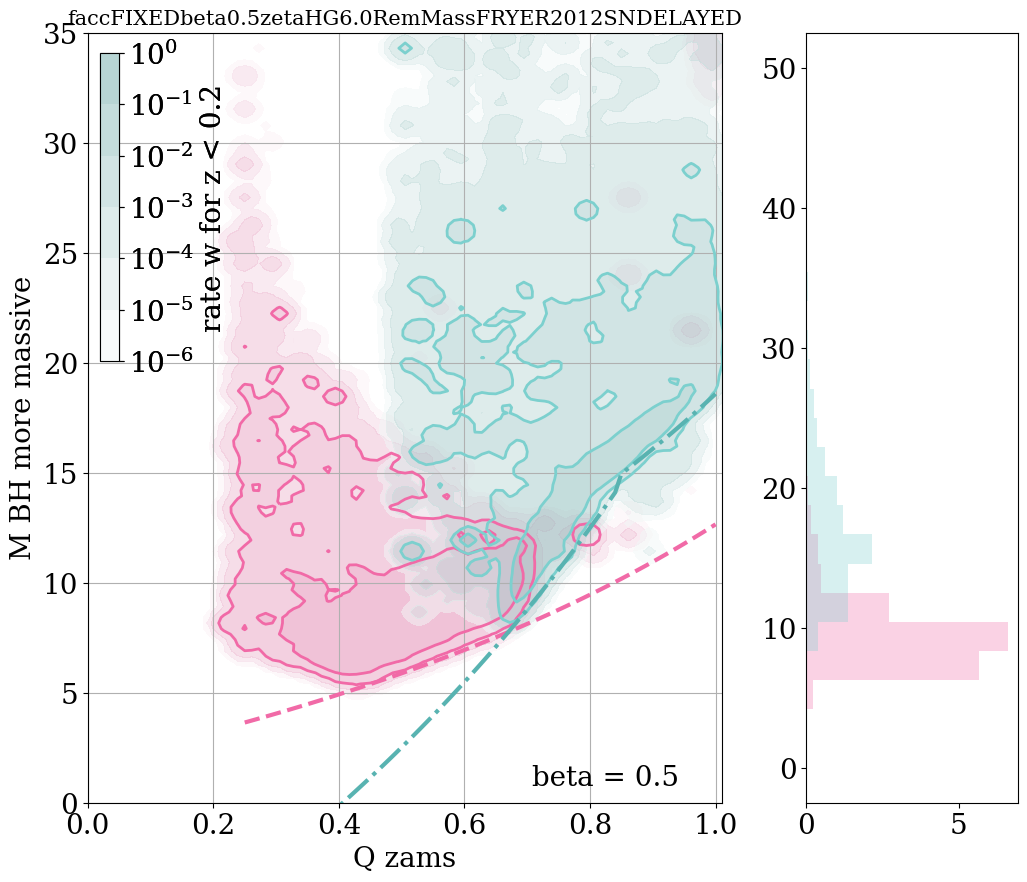

In [82]:
MRR_color = '#7CD0CE'
non_MRR_color = '#F16AA7'

# Create custom colormaps that fade from the color to white
non_MRR_cmap = LinearSegmentedColormap.from_list('non_MRR', ['white', darken_color(non_MRR_color, 0.9) ])
MRR_cmap = LinearSegmentedColormap.from_list('MRR', ['white', darken_color(MRR_color, 0.8) ])
cmaps = [non_MRR_cmap, MRR_cmap]


BETA = 0.5
sim_name = 'faccFIXEDbeta0.5zetaHG6.0RemMassFRYER2012SNDELAYED'


# Get analytical solutions
merging_BBH, Red_intr_rate_dens, Min_MBH1, minM_BH2, MZAMS_list, qzams, qcrit2_list, zeta_list =\
    get_table_and_min_MBH(beta = BETA, zeta_list = [6.0], Fc1 =1.0*0.34, sim_name = sim_name) #

M1_moremass_BBH = merging_BBH[merging_BBH['M_moreMassive'] == merging_BBH['Mass(1)'] ]
M2_moremass_BBH = merging_BBH[merging_BBH['M_moreMassive'] == merging_BBH['Mass(2)'] ]

i_redshift = np.where(redshifts == 0.2)[0][0]
M1_moremass_Weights = Red_intr_rate_dens[merging_BBH['M_moreMassive'] == merging_BBH['Mass(1)'], i_redshift]
M2_moremass_Weights = Red_intr_rate_dens[merging_BBH['M_moreMassive'] == merging_BBH['Mass(2)'], i_redshift]

Weights_list = [M1_moremass_Weights, M2_moremass_Weights]
colors = [non_MRR_color, MRR_color]

##########################
# Scatter plot
##########################
fig = plt.figure(figsize=(12, 10))

# Create a gridspec
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])

#######################
# Create the first axes for the contour plot
ax = plt.subplot(gs[0])

# Create the second axes for the y-value histogram
ax2 = plt.subplot(gs[1])

# Define the bins and levels
x_bins = np.linspace(0, 1.1, 100)
y_bins = np.linspace(0, 50, 200)
# Adjust the levels to the new y values # !!!
levels = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]

for i, to_plot_table in enumerate([M1_moremass_BBH, M2_moremass_BBH]):
    # to_plot_table = merging_BBH # M2_moremass_BBH 
    to_plot_table['qZAMS'] = to_plot_table['Mass@ZAMS(2)']/to_plot_table['Mass@ZAMS(1)']
    to_plot_weight =  Weights_list[i] #Weights #  M2_moremass_Weights #
    
    # Create a 2D histogram
    hist, x_edges, y_edges = np.histogram2d(to_plot_table['qZAMS'], to_plot_table['M_moreMassive'],
                                            bins=[x_bins, y_bins], weights= to_plot_weight)
    # Apply a Gaussian filter to the histogram
    hist = gaussian_filter(hist, sigma=0.9)

    # Create the contour plot
    im = ax.contourf((x_edges[:-1] + x_edges[1:])/2, (y_edges[:-1] + y_edges[1:])/2, hist.T, 
                levels=levels, alpha = 0.5, cmap=cmaps[i], norm=LogNorm() )
    # Add contour lines
    contour_lines = ax.contour((x_edges[:-1] + x_edges[1:])/2, (y_edges[:-1] + y_edges[1:])/2, hist.T, 
                levels=levels[3:], colors=colors[i], linewidths=2)
    
    # Create an inset axes for the colorbar
    cax = inset_axes(ax,
                    width="3%",  # width = 5% of parent_bbox width
                    height="40%",  # height : 50%
                    loc='upper left', bbox_to_anchor=(0.0, -0.01, 1, 1), bbox_transform=ax.transAxes)
    cbar = fig.colorbar(im, cax=cax, orientation="vertical",label = 'rate w for z < 0.2')

    # #######################
    # # Create the histogram interpolating to new y values 
    hist_bins = np.linspace(0,50,25)
    ax2.hist(to_plot_table['M_moreMassive'], bins= hist_bins, weights = to_plot_weight,
            orientation='horizontal', color=colors[i], alpha=0.3)
    

# #######
# Plot analytical solutions
ax.plot(qzams, Min_MBH1, color = non_MRR_color, lw = 3, ls = '--', label = 'min Mbha')
ax.plot(qzams, minM_BH2, color = '#58B3B1', lw = 3, ls = '-.', label = 'min Mbhb')

# Increase number of x ticks
# ax.xaxis.set_major_locator(plt.LinearLocator(8))
# ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

#######
ax.text(0.7, 0.05, 'beta = %s' % (BETA), ha='left', va='top', transform=ax.transAxes, size=20)

ax.set_xlabel('Q zams')
ax.set_ylabel('M BH more massive')

ax.set_ylim(0,35)
ax.set_xlim(0,1.01)

ax.grid(True)

ax.set_title(sim_name, fontsize =15)
plt.savefig('../Plots/qzams_vs_MBH1_beta0.5.pdf', bbox_inches='tight')
plt.show()

# Convey constant weight in IMF

I'm trying to represent the y-axis relative to the IMF weights. 
Assuming that the IMF follows the powerlaw: 

\begin{equation}
PDF = m^{-\alpha} m^{-2.3}
\end{equation}

where I've used $\alpha = 2.3$
then the CDF

\begin{equation}
CDF = \int_{-inf}^{x} m^{-2.3} dm  = \frac{-1}{1.3} x^{-1.3}
\end{equation}


The probability for some value to be in a bin is $CDF(y_i + \Delta y) - CDF(y)$
I'm tring to solve when this will be constant. I.e., I'm looking for a function of $\Delta y$ such that 

\begin{equation}
 CDF(y_i + \Delta y) - CDF(y)  = const 
\end{equation}

writing this out we get

\begin{equation}
 \frac{-1}{\alpha - 1} \Biggl( y_i + \Delta y \Biggr) ^{-\alpha + 1} + \frac{1}{\alpha - 1} y_i^{\alpha + 1} = const 
\end{equation}

or again with $\alpha = 2.3$ 

\begin{equation}
 \frac{-1}{1.3} \Biggl( y_i + \Delta y \Biggr) ^{-1.3} + \frac{1}{1.3} y_i^{-1.3} = c 
\end{equation}

Solving this for $\Delta y$ we get:


\begin{equation}
\boxed{
 \Delta y = \Biggl( \frac{- c * (\alpha-1)}{k} + y_i^{(1-\alpha)} \Biggr)^{1/(1-\alpha)}  - y_i
}
\end{equation}



In [53]:
# Equation to determine the delta_y needed to get a constant CDF
def delta_y(y_i, a = 2.3, k = 1, c = 1e-3):
    """
    yi: y value to start from
    Assuming a powerlaw: k x**-a
    a: power law index 
    k: constant 
    c: constant CDF difference, 
    e.g., how 'probable' you want your bin step to be
    """
    return ( -c *(a-1)/k  +  y_i**(1-a) )**(1/(1-a))  - y_i
    
# Bottom value of your y array
y_start = 5

# Itteratively calculate the y values
Y_ticks = [y_start]
y = y_start
while y < 45: 
    dy = delta_y(y, a = 2.3, k = 1, c = 5e-3) 
    print('y', y, 'dy', dy, 'y+dy', y+dy)
    y += dy
    Y_ticks.append(y)
    
print('Y_ticks', Y_ticks)

print('constant CDF? ', -1/1.3 * np.array([Y_ticks[i]**-1.3 - Y_ticks[i+1]**-1.3 for i in range(len(Y_ticks)-1)]) )



y 5 dy 0.2125040674024028 y+dy 5.212504067402403
y 5.212504067402403 dy 0.23449301464650585 y+dy 5.446997082048909
y 5.446997082048909 dy 0.260264834384512 y+dy 5.707261916433421
y 5.707261916433421 dy 0.29076407351119116 y+dy 5.998025989944612
y 5.998025989944612 dy 0.3272548956362087 y+dy 6.3252808855808205
y 6.3252808855808205 dy 0.3714619173687632 y+dy 6.696742802949584
y 6.696742802949584 dy 0.42578989120907007 y+dy 7.122532694158654
y 7.122532694158654 dy 0.49367747426287867 y+dy 7.616210168421532
y 7.616210168421532 dy 0.5801883414939324 y+dy 8.196398509915465
y 8.196398509915465 dy 0.6930425541647605 y+dy 8.889441064080225
y 8.889441064080225 dy 0.8445111668941028 y+dy 9.733952230974328
y 9.733952230974328 dy 1.0551206742160542 y+dy 10.789072905190382
y 10.789072905190382 dy 1.3614787304247677 y+dy 12.15055163561515
y 12.15055163561515 dy 1.834522853442106 y+dy 13.985074489057256
y 13.985074489057256 dy 2.628049194519532 y+dy 16.613123683576788
y 16.613123683576788 dy 4.1340521

# Now let's scale our y axis

In [54]:
m_up = np.arange(5, 50, 5)[::-1]
print(m_up)
print([m_up[i] for i in range(len(m_up)-1)])
print([m_up[i+1] for i in range(len(m_up)-1)])

# a = np.array([m_up[i]**-1.3 for i in range(len(m_up)-1)])
# b = np.array([m_up[i+1]**-1.3 for i in range(len(m_up)-1)])
# c = -1.3*(a-b)
# print('a-b', c)

# print(-1.3*(45**-1.3 - 40**-1.3) )

print(-1/1.3 * np.array([m_up[i]**-1.3 - m_up[i+1]**-1.3 for i in range(len(m_up)-1)]) )




[45 40 35 30 25 20 15 10  5]
[np.int64(45), np.int64(40), np.int64(35), np.int64(30), np.int64(25), np.int64(20), np.int64(15), np.int64(10)]
[np.int64(40), np.int64(35), np.int64(30), np.int64(25), np.int64(20), np.int64(15), np.int64(10), np.int64(5)]
[0.00090278 0.00120544 0.00167841 0.00247209 0.00394253 0.00710088
 0.01579466 0.05637542]


## Plottin q vs M with re-weighted y-ticks

/var/folders/5d/vcxrsh5975l7d5n8t7vvc5pr0000gn/T/ipykernel_43376/3922771299.py:2: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter


Reading  ../data/faccFIXEDbeta0.5zetaHG6.0RemMassFRYER2012SNDELAYED/COMPAS_Output_wWeights.h5
using keys <KeysViewHDF5 ['BSE_Double_Compact_Objects', 'BSE_RLOF', 'Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_zBinned']> <KeysViewHDF5 ['CE_Event_Counter', 'Immediate_RLOF>CE', 'MT_Donor_Hist(1)', 'MT_Donor_Hist(2)', 'Mass(1)', 'Mass(2)', 'Mass@ZAMS(1)', 'Mass@ZAMS(2)', 'Merges_Hubble_Time', 'Metallicity@ZAMS(1)', 'Optimistic_CE', 'SEED', 'Stellar_Type(1)', 'Stellar_Type(2)', 'Stellar_Type@ZAMS(1)', 'Stellar_Type@ZAMS(2)', 'mixture_weight']>
Done with reading DCO data for this file :)
you are using  CE_Event_Counter which should be in  ['SEED', 'Mass(1)', 'Mass(2)', 'Stellar_Type(1)', 'Stellar_Type(2)', 'Metallicity@ZAMS(1)', 'Mass@ZAMS(1)', 'Mass@ZAMS(2)', 'CE_Event_Counter', 'M_moreMassive', 'M_lessMassive', 'Mchirp']
done masking data:  0.30832910537719727 seconds
<Table length=225858>
        name         dtype 
------------------- -------
               SEED  uint64
     

/var/folders/5d/vcxrsh5975l7d5n8t7vvc5pr0000gn/T/ipykernel_43376/3922771299.py:62: UserWarning: Log scale: values of z <= 0 have been masked
  im = ax.contourf((x_edges[:-1] + x_edges[1:])/2, (y_edges[:-1] + y_edges[1:])/2, hist.T,


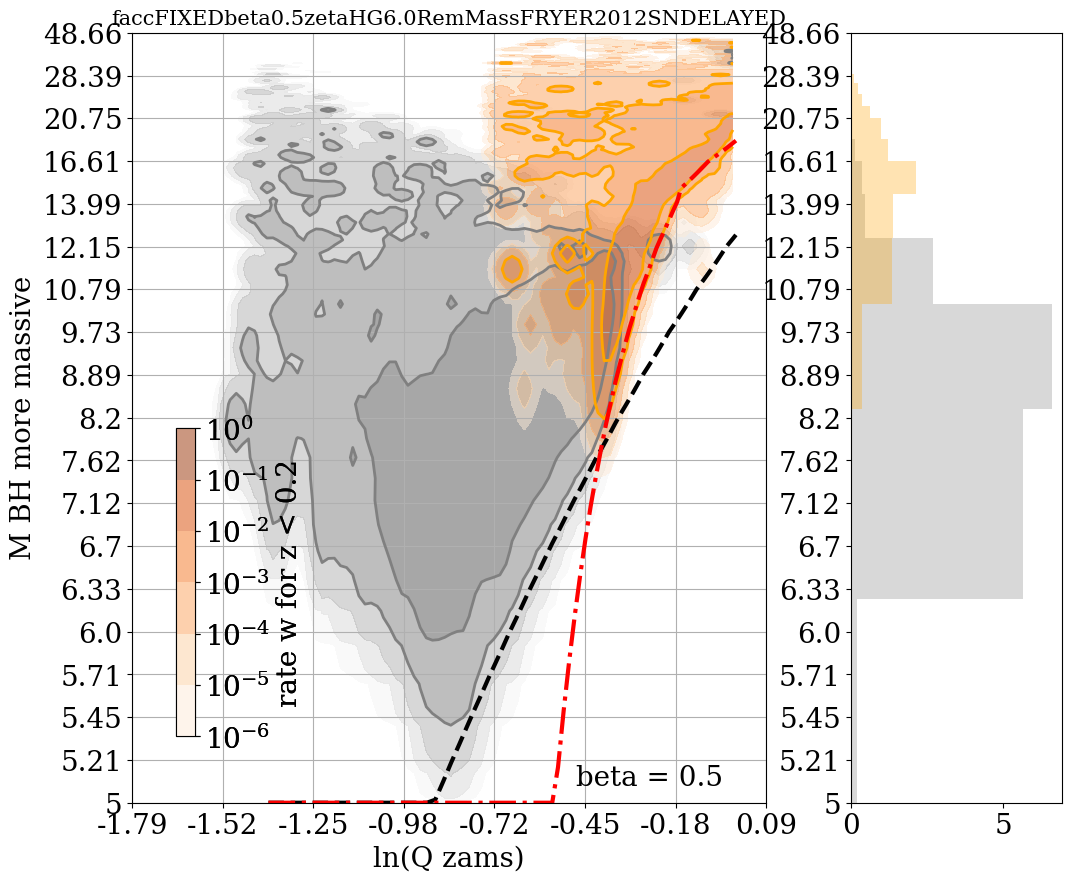

In [ ]:
from matplotlib.colors import LogNorm
from scipy.ndimage.filters import gaussian_filter
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FormatStrFormatter

BETA = 0.5
sim_name = 'faccFIXEDbeta0.5zetaHG6.0RemMassFRYER2012SNDELAYED'
     
merging_BBH, Red_intr_rate_dens, Min_MBH1, minM_BH2, MZAMS_list, qzams, qcrit2_list, zeta_list =\
    get_table_and_min_MBH(beta = BETA, zeta_list = [6.0], Fc1 =1.0*0.34, sim_name = sim_name) #

M1_moremass_BBH = merging_BBH[merging_BBH['M_moreMassive'] == merging_BBH['Mass(1)'] ]
M2_moremass_BBH = merging_BBH[merging_BBH['M_moreMassive'] == merging_BBH['Mass(2)'] ]

i_redshift = np.where(redshifts == 0.2)[0][0]
M1_moremass_Weights = Red_intr_rate_dens[merging_BBH['M_moreMassive'] == merging_BBH['Mass(1)'], i_redshift]
M2_moremass_Weights = Red_intr_rate_dens[merging_BBH['M_moreMassive'] == merging_BBH['Mass(2)'], i_redshift]

Weights_list = [M1_moremass_Weights, M2_moremass_Weights]
colors = ['Grey', 'Orange']

##########################
# Scatter plot
##########################
fig = plt.figure(figsize=(12, 10))

# Create a gridspec
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])

#######################
# Create the first axes for the contour plot
ax = plt.subplot(gs[0])

# First define new y values
new_Y_ticks = np.linspace(0, 1, len(Y_ticks))

# Create the second axes for the y-value histogram
ax2 = plt.subplot(gs[1])

# Define the bins and levels
x_bins = np.linspace(-1.8,0,100) #np.linspace(0, 1.1, 100)
y_bins = np.linspace(0, 50, 200)
# Adjust the levels to the new y values
new_y_bins = np.interp(y_bins, Y_ticks, new_Y_ticks)
levels = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]

for i, to_plot_table in enumerate([M1_moremass_BBH, M2_moremass_BBH]):
    # to_plot_table = merging_BBH # M2_moremass_BBH 
    to_plot_table['qZAMS'] = to_plot_table['Mass@ZAMS(2)']/to_plot_table['Mass@ZAMS(1)']
    to_plot_weight =  Weights_list[i] #Weights #  M2_moremass_Weights #
    
    # Create a 2D histogram
    new_y_vals = np.interp(to_plot_table['M_moreMassive'], Y_ticks, new_Y_ticks) 
    hist, x_edges, y_edges = np.histogram2d(np.log(to_plot_table['qZAMS']), new_y_vals,
                                            bins=[x_bins, new_y_bins], weights= to_plot_weight)

    # Apply a Gaussian filter to the histogram
    hist = gaussian_filter(hist, sigma=0.9)

    # Create the contour plot
    im = ax.contourf((x_edges[:-1] + x_edges[1:])/2, (y_edges[:-1] + y_edges[1:])/2, hist.T, 
                levels=levels, alpha = 0.5, cmap=colors[i]+'s', norm=LogNorm() )
    # Add contour lines
    contour_lines = ax.contour((x_edges[:-1] + x_edges[1:])/2, (y_edges[:-1] + y_edges[1:])/2, hist.T, 
                levels=levels[3:], colors=colors[i], linewidths=2)
    
    # Create an inset axes for the colorbar
    cax = inset_axes(ax,
                    width="3%",  # width = 5% of parent_bbox width
                    height="40%",  # height : 50%
                    loc='lower left', bbox_to_anchor=(0.05, 0.07, 1, 1), bbox_transform=ax.transAxes)
    cbar = fig.colorbar(im, cax=cax, orientation="vertical",label = 'rate w for z < 0.2')

    # #######################
    # # Create the histogram interpolating to new y values 
    hist_bins = np.linspace(0,50,25)
    ax2.hist(np.interp(to_plot_table['M_moreMassive'], Y_ticks, new_Y_ticks), bins= np.interp(hist_bins, Y_ticks, new_Y_ticks), weights = to_plot_weight,
            orientation='horizontal', color=colors[i], alpha=0.3)
    
# #######
# map your old y values to the new y values using np.interp
ax.plot(np.log(qzams), np.interp(Min_MBH1, Y_ticks, new_Y_ticks), color = 'k', lw = 3, ls = '--', label = 'min Mbha')
ax.plot(np.log(qzams), np.interp(minM_BH2, Y_ticks, new_Y_ticks), color = 'red', lw = 3, ls = '-.', label = 'min Mbhb')

# Increase number of x ticks
ax.xaxis.set_major_locator(plt.LinearLocator(8))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# Set the y-ticks and y-ticklabels
ax.set_yticks(new_Y_ticks)
ax.yaxis.set_ticklabels([np.round(y,2) for y in Y_ticks]) # change the ticks' names to y
ax.set_ylim(new_Y_ticks[0], new_Y_ticks[-1])

# Also for the second axis
ax2.set_yticks(new_Y_ticks)
ax2.yaxis.set_ticklabels([np.round(y,2) for y in Y_ticks]) # change the ticks' names to y
ax2.set_ylim(new_Y_ticks[0], new_Y_ticks[-1])

#######
ax.text(0.7, 0.05, 'beta = %s' % (BETA), ha='left', va='top', transform=ax.transAxes, size=20)

ax.set_xlabel('ln(Q zams)')
ax.set_ylabel('M BH more massive')

# ax.set_xlim(0,1.1)

ax.grid(True)

ax.set_title(sim_name, fontsize =15)

plt.show()